In [1]:
from numpy import argmax
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
y_pred = [ 0.66, 0.52, 0.77]
Y_test = [0.6, 0.5,  0.7]

r2 = r2_score(Y_test, y_pred)
print('r2 ',r2)

r2  0.554999999999999


In [3]:
y_pred = [0.52, 0.66, 0.77]
Y_test = [0.5, 0.6, 0.7]

r2 = r2_score(Y_test, y_pred)
print('r2 ',r2)

r2  0.554999999999999


In [4]:
y_pred = [0.52, 0.66, 0.77]
Y_test = [0.5, 0.6, 0.7]

r2 = r2_score(y_pred, Y_test)
print('r2 ',r2)

r2  0.7165605095541396


In [5]:
import pandas as pd

In [6]:
import numpy as np

df = pd.read_csv("All_external_test_Sets.csv")
df

,smiles_r,human_CL_mL_min_kg,human_VDss_L_kg,human_fup,human_thalf
0,C/[NH+]=C1/C[NH+](O)C(c2ccccc2)=c2cc(Cl)ccc2=N1,0.37,0.25,NaN,NaN
1,C1=C/COCc2cc(ccc2OCC[NH+]2CCCC2)Nc2nccc(n2)-c2...,0.58,3.82,0.01,27.7
2,C=C/C=C/C[C@@H](C)[C@@H](O)C1C(=O)NC(CC)C(=O)[...,17.67,35.90,0.03,30.0
3,C=C1CC[C@]2(O)[C@@H]3Cc4ccc([O-])c5c4[C@]2(CC[...,14.40,NaN,NaN,NaN
4,C=C1C[C@@H]2C(CC[C@]3(C)C(=O)CC[C@@H]23)[C@]2(...,145.00,NaN,NaN,NaN
...,...,...,...,...,...
310,[O-]c1ccc(CC[NH2+]CCCCCC[NH2+]CCc2ccccc2)cc1[O-],36.00,NaN,NaN,NaN
311,[O-]c1ccc2c(c1)C13CCCC[C@@]1(O)[C@H](C2)[NH+](...,40.00,NaN,NaN,NaN
312,[O-]c1ccc2c3c1O[C@@H]1[C@@H](O)CC[C@]4(O)[C@H]...,29.70,NaN,NaN,NaN
313,[O-]c1ncnc2[n-]ncc12,9.90,NaN,NaN,NaN


In [7]:
#df = df[df["source"]!="Lombardo"].reset_index(drop=True)
#df

In [8]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import inchi
from rdkit.Chem.MolStandardize import rdMolStandardize
import pickle
from mordred import Calculator, descriptors
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from sklearn.feature_selection import VarianceThreshold
from itertools import compress
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pickle

from dimorphite_dl.dimorphite_dl import DimorphiteDL
from rdkit.Chem import AddHs
from rdkit.Chem.MolStandardize import rdMolStandardize

def standardize(smiles):
    # follows the steps in
    # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
    # as described **excellently** (by Greg) in
    # https://www.youtube.com/watch?v=eWTApNX8dJQ
    try: 
        mol = Chem.MolFromSmiles(smiles)
        #print(smiles)
        
        # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
        clean_mol = rdMolStandardize.Cleanup(mol) 
        #print(Chem.MolToSmiles(clean_mol))
        
        # if many fragments, get the "parent" (the actual mol we are interested in) 
        parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

        # try to neutralize molecule
        uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
        uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)

        #print(uncharged_parent_clean_mol)
        
        # use pH 7.4 https://git.durrantlab.pitt.edu/jdurrant/dimorphite_dl/
        dimorphite = DimorphiteDL(min_ph=7.4, max_ph=7.4, pka_precision=0)
        protonated_smiles = dimorphite.protonate(Chem.MolToSmiles(uncharged_parent_clean_mol))

        #print("protonated_smiles")
        
        if len(protonated_smiles) > 0:
                protonated_smile = protonated_smiles[0]

        protonated_mol = Chem.MolFromSmiles(protonated_smile)
        #protonated_mol= AddHs(protonated_mol)
        #protonated_smile = Chem.MolToSmiles(protonated_mol)


        # attempt is made at reionization at this step
        # at 7.4 pH

        te = rdMolStandardize.TautomerEnumerator() # idem
        taut_uncharged_parent_clean_mol = te.Canonicalize(protonated_mol)
     
        return  Chem.MolToSmiles(taut_uncharged_parent_clean_mol)
    
    except: 
        
        return "Cannot_do"

    
def calcdesc(data):
    # create descriptor calculator with all descriptors
    calc = Calculator(descriptors, ignore_3D=True)

    #print(len(calc.descriptors))
    Ser_Mol = data['smiles_r'].apply(Chem.MolFromSmiles)
    Mordred_table=  calc.pandas(Ser_Mol)
    Mordred_table = Mordred_table.astype('float')
    Mordred_table['smiles_r'] = data['smiles_r']
    
    Morgan_fingerprint= Ser_Mol.apply(GetMorganFingerprintAsBitVect, args=(2, 2048))
    Morganfingerprint_array  = np.stack(Morgan_fingerprint)

    Morgan_collection  = []
    for x in np.arange(Morganfingerprint_array.shape[1]): #np.arange plus rapide que range
        x = "Mfp"+str(x)
        Morgan_collection.append(x)

    Morganfingerprint_table  = pd.DataFrame(Morganfingerprint_array , columns=Morgan_collection )
    Morganfingerprint_table['smiles_r'] = data['smiles_r']
    
    data_mfp = pd.merge(data, Morganfingerprint_table)
    data_mfp_Mordred = pd.merge(data_mfp, Mordred_table)
    
    return(data_mfp_Mordred)
    

def predict_individual_animal(data, endpoint, animal):#predict animal data
    
    #Read columns needed for rat data
    file = open(f"../features_mfp_mordred_columns_{animal}_model.txt", "r")
    file_lines = file.read()
    features = file_lines.split("\n")
    features = features[:-1]

    loaded_rf = pickle.load(open(f"../log_{endpoint}_model_FINAL.sav", 'rb'))

    X = data[features]
    
    #Replace missing descriptors with median

    animalmedian = pd.read_csv(f"../Median_mordred_values_{animal}_for_artificial_animal_data_mfp_mrd_model.csv")

    for i in X.columns[X.isna().any()].tolist():
        #print(i)
        X[i].fillna(float(animalmedian[i]), inplace=True)
    
    # Load the scaler from the file
    with open(f'../scaler_{animal}.pkl', 'rb') as file:
        scaler = pickle.load(file)

    # Scale the features using the loaded scaler
    X_new = scaler.transform(X)
    X_new = pd.DataFrame(X_new, columns=features)
    
    y_pred =  loaded_rf.predict(X_new)   

    return(y_pred)

def predict_animal(data):
    
    endpoints = {"dog_VDss_L_kg","dog_CL_mL_min_kg","dog_fup"}

    for endpoint in endpoints:
        preds = predict_individual_animal(data, endpoint, "dog") 
        data[endpoint] = preds

    endpoints = {"monkey_VDss_L_kg","monkey_CL_mL_min_kg","monkey_fup"}

    for endpoint in endpoints:
        preds = predict_individual_animal(data, endpoint, "monkey") 
        data[endpoint] = preds
    
    endpoints = {"rat_VDss_L_kg","rat_CL_mL_min_kg","rat_fup"}

    for endpoint in endpoints:
        preds = predict_individual_animal(data, endpoint, "rat") 
        data[endpoint] = preds
    
    return(data)



def predict_VDss(data, features):#
    

    loaded_rf = pickle.load(open("../log_human_VDss_L_kg_withanimaldata_artificial_model_FINAL.sav", 'rb'))

    X = data[features].values
    
    # Load the scaler from the file
    with open(f'../artificial_animal_data_mfp_mrd_human_VDss_L_kg_scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)

    # Scale the features using the loaded scaler
    X = scaler.transform(X)
    X = pd.DataFrame(X, columns=features)
    y_preds =  loaded_rf.predict(X)   

    return(y_preds)

def predict_CL(data, features):

    loaded_rf = pickle.load(open("../log_human_CL_mL_min_kg_withanimaldata_artificial_model_FINAL.sav", 'rb'))

    X = data[features].values
    # Load the scaler from the file
    with open(f'../artificial_animal_data_mfp_mrd_human_CL_mL_min_kg_scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)

    # Scale the features using the loaded scaler
    X = scaler.transform(X)
    X = pd.DataFrame(X, columns=features)
    y_preds =  loaded_rf.predict(X)   

    return(y_preds)

def predict_fup(data, features):
    
    loaded_rf = pickle.load(open("../log_human_fup_withanimaldata_artificial_model_FINAL.sav", 'rb'))

    X = data[features].values
    # Load the scaler from the file
    with open(f'../artificial_animal_data_mfp_mrd_human_fup_scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)

    # Scale the features using the loaded scaler
    X = scaler.transform(X)
    X = pd.DataFrame(X, columns=features)
    y_preds =  loaded_rf.predict(X)   

    return(y_preds)

def predict_MRT(data, features):
    
    

    loaded_rf = pickle.load(open("../log_human_mrt_withanimaldata_artificial_model_FINAL.sav", 'rb'))

    X = data[features].values
    # Load the scaler from the file
    with open(f'../artificial_animal_data_mfp_mrd_human_mrt_scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)

    # Scale the features using the loaded scaler
    X = scaler.transform(X)
    X = pd.DataFrame(X, columns=features)
    y_preds =  loaded_rf.predict(X)   

    return(y_preds)

def predict_thalf(data, features):
    
    loaded_rf = pickle.load(open("../log_human_thalf_withanimaldata_artificial_model_FINAL.sav", 'rb'))

    X = data[features].values
    # Load the scaler from the file
    with open(f'../artificial_animal_data_mfp_mrd_human_thalf_scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)

    # Scale the features using the loaded scaler
    X = scaler.transform(X)
    X = pd.DataFrame(X, columns=features)
    y_preds =  loaded_rf.predict(X)  
    return(y_preds)

In [9]:
from pandarallel import pandarallel
pandarallel.initialize()

df["smiles_r"] = df["smiles_r"].parallel_apply(standardize)

INFO: Pandarallel will run on 56 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [10]:
def count(pred, true, min, max, endpoint):

    if(endpoint == "human_fup"):
        lst = [abs(a/b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    else:
        lst = [abs(10**a/10**b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    return

def calc_gmfe(pred, true, endpoint):
    
    if(endpoint == "human_fup"):
        
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        return (10**mean_abs)
    
    else: 
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        
        return (10** mean_abs)
    
    return
                         
def median_fold_change_error(pred, true, endpoint):
                         
    if (endpoint == "human_fup"):
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    else:
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    return
                          
def calc_bias(pred, true, endpoint):
                          
    if (endpoint == "human_fup"):
        lst = [(a - b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    else:
        lst = [(10**a - 10**b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    return

In [11]:
df

,smiles_r,human_CL_mL_min_kg,human_VDss_L_kg,human_fup,human_thalf
0,C/[NH+]=C1/C[NH+](O)C(c2ccccc2)=c2cc(Cl)ccc2=N1,0.37,0.25,NaN,NaN
1,C1=C/COCc2cc(ccc2OCC[NH+]2CCCC2)Nc2nccc(n2)-c2...,0.58,3.82,0.01,27.7
2,C=C/C=C/C[C@@H](C)[C@@H](O)C1C(=O)NC(CC)C(=O)[...,17.67,35.90,0.03,30.0
3,C=C1CC[C@]2(O)[C@@H]3Cc4ccc([O-])c5c4[C@]2(CC[...,14.40,NaN,NaN,NaN
4,C=C1C[C@@H]2C(CC[C@]3(C)C(=O)CC[C@@H]23)[C@]2(...,145.00,NaN,NaN,NaN
...,...,...,...,...,...
310,[O-]c1ccc(CC[NH2+]CCCCCC[NH2+]CCc2ccccc2)cc1[O-],36.00,NaN,NaN,NaN
311,[O-]c1ccc2c(c1)C13CCCC[C@@]1(O)[C@H](C2)[NH+](...,40.00,NaN,NaN,NaN
312,[O-]c1ccc2c3c1O[C@@H]1[C@@H](O)CC[C@]4(O)[C@H]...,29.70,NaN,NaN,NaN
313,[O-]c1ncnc2[n-]ncc12,9.90,NaN,NaN,NaN


In [12]:
animal_columns = ["dog_VDss_L_kg","dog_CL_mL_min_kg","dog_fup","monkey_VDss_L_kg","monkey_CL_mL_min_kg","monkey_fup", "rat_VDss_L_kg","rat_CL_mL_min_kg","rat_fup"]

#read from file features
file = open("../features_mfp_mordred_columns_human.txt", "r")
file_lines = file.read()
features_mfp_mordred_columns = file_lines.split("\n")
features_mfp_mordred_columns = features_mfp_mordred_columns[:-1]

In [13]:
features_mfp_mordred_columns

['nAcid',
 'nBase',
 'SpDiam_A',
 'VE1_A',
 'VR1_A',
 'VR3_A',
 'nBridgehead',
 'nHetero',
 'nH',
 'nN',
 'nO',
 'nS',
 'nP',
 'nF',
 'nX',
 'ATS0dv',
 'ATS4dv',
 'ATS2s',
 'ATS4s',
 'ATS4m',
 'ATS5i',
 'ATS8i',
 'AATS1dv',
 'AATS2dv',
 'AATS3dv',
 'AATS0d',
 'AATS2d',
 'AATS3d',
 'AATS0s',
 'AATS1s',
 'AATS2s',
 'AATS3s',
 'AATS1m',
 'AATS3m',
 'AATS1v',
 'AATS3v',
 'AATS1are',
 'AATS2are',
 'AATS3are',
 'AATS0p',
 'AATS0i',
 'AATS1i',
 'AATS2i',
 'AATS3i',
 'ATSC0c',
 'ATSC1c',
 'ATSC2c',
 'ATSC3c',
 'ATSC4c',
 'ATSC5c',
 'ATSC6c',
 'ATSC7c',
 'ATSC8c',
 'ATSC1dv',
 'ATSC2dv',
 'ATSC3dv',
 'ATSC4dv',
 'ATSC5dv',
 'ATSC6dv',
 'ATSC7dv',
 'ATSC8dv',
 'ATSC1d',
 'ATSC2d',
 'ATSC3d',
 'ATSC4d',
 'ATSC5d',
 'ATSC6d',
 'ATSC7d',
 'ATSC8d',
 'ATSC1s',
 'ATSC2s',
 'ATSC3s',
 'ATSC4s',
 'ATSC5s',
 'ATSC6s',
 'ATSC7s',
 'ATSC8s',
 'ATSC1Z',
 'ATSC2Z',
 'ATSC5Z',
 'ATSC6Z',
 'ATSC0m',
 'ATSC3m',
 'ATSC4m',
 'ATSC7m',
 'ATSC8m',
 'ATSC1v',
 'ATSC2v',
 'ATSC3v',
 'ATSC4v',
 'ATSC5v',
 'ATSC6v',
 

In [14]:
len(features_mfp_mordred_columns)

504

In [15]:
data_mfp_Mordred = calcdesc(df)
data_mfp_Mordred

 12%|████▉                                     | 37/315 [00:01<00:07, 38.12it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 47%|███████████████████▏                     | 147/315 [00:02<00:01, 99.80it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 87%|███████████████████████████████████▋     | 274/315 [00:04<00:00, 71.25it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|█████████████████████████████████████████| 315/315 [00:05<00:00, 59.90it/s]


,smiles_r,human_CL_mL_min_kg,human_VDss_L_kg,human_fup,human_thalf,Mfp0,Mfp1,Mfp2,Mfp3,Mfp4,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,C/[NH+]=C1/C[NH+](O)C(c2ccccc2)=c2cc(Cl)ccc2=N1,0.37,0.25,NaN,NaN,0,0,0,0,0,...,9.949751,63.023277,301.097093,8.137759,828.0,37.0,110.0,130.0,6.527778,4.694444
1,C1=C/COCc2cc(ccc2OCC[NH+]2CCCC2)Nc2nccc(n2)-c2...,0.58,3.82,0.01,27.7,0,0,0,0,0,...,10.236346,84.096047,473.254717,6.959628,3973.0,51.0,180.0,206.0,7.638889,7.805556
2,C=C/C=C/C[C@@H](C)[C@@H](O)C1C(=O)NC(CC)C(=O)[...,17.67,35.90,0.03,30.0,0,1,0,0,0,...,11.211996,126.438462,1220.892303,5.984766,38625.0,151.0,416.0,481.0,43.500000,19.416667
3,C=C1CC[C@]2(O)[C@@H]3Cc4ccc([O-])c5c4[C@]2(CC[...,14.40,NaN,NaN,NaN,0,0,0,0,0,...,10.930622,81.595235,339.183444,6.783669,1189.0,59.0,160.0,211.0,6.875000,5.034722
4,C=C1C[C@@H]2C(CC[C@]3(C)C(=O)CC[C@@H]23)[C@]2(...,145.00,NaN,NaN,NaN,0,0,0,0,0,...,10.596660,71.984835,296.177630,6.438644,892.0,47.0,132.0,168.0,7.902778,4.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,[O-]c1ccc(CC[NH2+]CCCCCC[NH2+]CCc2ccccc2)cc1[O-],36.00,NaN,NaN,NaN,0,0,0,0,0,...,9.570459,59.431680,356.246378,6.142179,2557.0,30.0,118.0,127.0,7.444444,6.111111
311,[O-]c1ccc2c(c1)C13CCCC[C@@]1(O)[C@H](C2)[NH+](...,40.00,NaN,NaN,NaN,0,0,0,0,0,...,10.752719,60.334421,327.219829,6.173959,1145.0,50.0,144.0,183.0,6.291667,4.993056
312,[O-]c1ccc2c3c1O[C@@H]1[C@@H](O)CC[C@]4(O)[C@H]...,29.70,NaN,NaN,NaN,0,0,0,0,0,...,10.962024,77.785047,357.194008,6.739510,1356.0,60.0,164.0,215.0,7.125000,5.284722
313,[O-]c1ncnc2[n-]ncc12,9.90,NaN,NaN,NaN,0,0,0,0,0,...,9.161465,53.745115,134.023958,11.168663,105.0,12.0,52.0,61.0,2.833333,2.222222


In [16]:
data_mfp_Mordred_animal = predict_animal(data_mfp_Mordred)

/tmp/ipykernel_2610636/839182830.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i].fillna(float(animalmedian[i]), inplace=True)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/tmp/ipykernel_2610636/839182830.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i].fillna(float(animalmedian[i]), inplace=True)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor 

In [17]:
data_for_pred = data_mfp_Mordred_animal

#data_for_pred = data_for_pred.dropna(subset=["Clearance_(CL)"]).reset_index(drop=True)
#data_for_pred = data_for_pred.dropna(subset=["Volume_of_distribution_(VDss)"]).reset_index(drop=True)
data_for_pred 

,smiles_r,human_CL_mL_min_kg,human_VDss_L_kg,human_fup,human_thalf,Mfp0,Mfp1,Mfp2,Mfp3,Mfp4,...,mZagreb2,dog_CL_mL_min_kg,dog_VDss_L_kg,dog_fup,monkey_VDss_L_kg,monkey_CL_mL_min_kg,monkey_fup,rat_fup,rat_CL_mL_min_kg,rat_VDss_L_kg
0,C/[NH+]=C1/C[NH+](O)C(c2ccccc2)=c2cc(Cl)ccc2=N1,0.37,0.25,NaN,NaN,0,0,0,0,0,...,4.694444,1.411850,0.249248,0.167017,0.231611,1.120739,0.290952,0.148287,1.300099,0.309314
1,C1=C/COCc2cc(ccc2OCC[NH+]2CCCC2)Nc2nccc(n2)-c2...,0.58,3.82,0.01,27.7,0,0,0,0,0,...,7.805556,1.332049,0.495238,0.171952,0.351862,1.131486,0.250010,0.200152,1.627994,0.616605
2,C=C/C=C/C[C@@H](C)[C@@H](O)C1C(=O)NC(CC)C(=O)[...,17.67,35.90,0.03,30.0,0,1,0,0,0,...,19.416667,0.863305,-0.033957,0.419797,-0.016984,1.050424,0.500592,0.436332,1.258841,0.379705
3,C=C1CC[C@]2(O)[C@@H]3Cc4ccc([O-])c5c4[C@]2(CC[...,14.40,NaN,NaN,NaN,0,0,0,0,0,...,5.034722,1.713030,0.682646,0.463856,0.665839,1.618540,0.447864,0.496449,1.756518,0.781431
4,C=C1C[C@@H]2C(CC[C@]3(C)C(=O)CC[C@@H]23)[C@]2(...,145.00,NaN,NaN,NaN,0,0,0,0,0,...,4.500000,1.154710,0.578147,0.375463,0.568762,1.415701,0.329248,0.276459,1.438786,0.473626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,[O-]c1ccc(CC[NH2+]CCCCCC[NH2+]CCc2ccccc2)cc1[O-],36.00,NaN,NaN,NaN,0,0,0,0,0,...,6.111111,1.226740,0.275325,0.295856,0.224264,1.031842,0.323187,0.321082,1.528879,0.478352
311,[O-]c1ccc2c(c1)C13CCCC[C@@]1(O)[C@H](C2)[NH+](...,40.00,NaN,NaN,NaN,0,0,0,0,0,...,4.993056,1.676179,0.776239,0.371105,0.599810,1.494807,0.326047,0.340475,1.810510,0.711609
312,[O-]c1ccc2c3c1O[C@@H]1[C@@H](O)CC[C@]4(O)[C@H]...,29.70,NaN,NaN,NaN,0,0,0,0,0,...,5.284722,1.553609,0.675500,0.495485,0.590975,1.588949,0.478593,0.487810,1.731719,0.780821
313,[O-]c1ncnc2[n-]ncc12,9.90,NaN,NaN,NaN,0,0,0,0,0,...,2.222222,0.225159,-0.521590,0.713804,-0.013977,0.983331,0.525750,0.535695,1.074652,-0.226276


In [18]:
data_for_pred[["smiles_r" ,"dog_CL_mL_min_kg",
               "dog_fup","dog_VDss_L_kg","monkey_CL_mL_min_kg","monkey_VDss_L_kg",
               "monkey_fup","rat_CL_mL_min_kg","rat_fup","rat_VDss_L_kg"]].to_csv("All_Ext_test_animal_preds.csv", index=False)

data_for_pred[["smiles_r" ,"dog_CL_mL_min_kg",
               "dog_fup","dog_VDss_L_kg","monkey_CL_mL_min_kg","monkey_VDss_L_kg",
               "monkey_fup","rat_CL_mL_min_kg","rat_fup","rat_VDss_L_kg"]]

,smiles_r,dog_CL_mL_min_kg,dog_fup,dog_VDss_L_kg,monkey_CL_mL_min_kg,monkey_VDss_L_kg,monkey_fup,rat_CL_mL_min_kg,rat_fup,rat_VDss_L_kg
0,C/[NH+]=C1/C[NH+](O)C(c2ccccc2)=c2cc(Cl)ccc2=N1,1.411850,0.167017,0.249248,1.120739,0.231611,0.290952,1.300099,0.148287,0.309314
1,C1=C/COCc2cc(ccc2OCC[NH+]2CCCC2)Nc2nccc(n2)-c2...,1.332049,0.171952,0.495238,1.131486,0.351862,0.250010,1.627994,0.200152,0.616605
2,C=C/C=C/C[C@@H](C)[C@@H](O)C1C(=O)NC(CC)C(=O)[...,0.863305,0.419797,-0.033957,1.050424,-0.016984,0.500592,1.258841,0.436332,0.379705
3,C=C1CC[C@]2(O)[C@@H]3Cc4ccc([O-])c5c4[C@]2(CC[...,1.713030,0.463856,0.682646,1.618540,0.665839,0.447864,1.756518,0.496449,0.781431
4,C=C1C[C@@H]2C(CC[C@]3(C)C(=O)CC[C@@H]23)[C@]2(...,1.154710,0.375463,0.578147,1.415701,0.568762,0.329248,1.438786,0.276459,0.473626
...,...,...,...,...,...,...,...,...,...,...
310,[O-]c1ccc(CC[NH2+]CCCCCC[NH2+]CCc2ccccc2)cc1[O-],1.226740,0.295856,0.275325,1.031842,0.224264,0.323187,1.528879,0.321082,0.478352
311,[O-]c1ccc2c(c1)C13CCCC[C@@]1(O)[C@H](C2)[NH+](...,1.676179,0.371105,0.776239,1.494807,0.599810,0.326047,1.810510,0.340475,0.711609
312,[O-]c1ccc2c3c1O[C@@H]1[C@@H](O)CC[C@]4(O)[C@H]...,1.553609,0.495485,0.675500,1.588949,0.590975,0.478593,1.731719,0.487810,0.780821
313,[O-]c1ncnc2[n-]ncc12,0.225159,0.713804,-0.521590,0.983331,-0.013977,0.525750,1.074652,0.535695,-0.226276


In [19]:
file = open("../features_mfp_mordred_animal_artificial_human_modelcolumns.txt", "r")
file_lines = file.read()
features_mfp_mordred_animal_columns = file_lines.split("\n")
features_mfp_mordred_animal_columns = features_mfp_mordred_animal_columns[:-1]
features_mfp_mordred_animal_columns

['nAcid',
 'nBase',
 'SpDiam_A',
 'VE1_A',
 'VR1_A',
 'VR3_A',
 'nBridgehead',
 'nHetero',
 'nH',
 'nN',
 'nO',
 'nS',
 'nP',
 'nF',
 'nX',
 'ATS0dv',
 'ATS4dv',
 'ATS2s',
 'ATS4s',
 'ATS4m',
 'ATS5i',
 'ATS8i',
 'AATS1dv',
 'AATS2dv',
 'AATS3dv',
 'AATS0d',
 'AATS2d',
 'AATS3d',
 'AATS0s',
 'AATS1s',
 'AATS2s',
 'AATS3s',
 'AATS1m',
 'AATS3m',
 'AATS1v',
 'AATS3v',
 'AATS1are',
 'AATS2are',
 'AATS3are',
 'AATS0p',
 'AATS0i',
 'AATS1i',
 'AATS2i',
 'AATS3i',
 'ATSC0c',
 'ATSC1c',
 'ATSC2c',
 'ATSC3c',
 'ATSC4c',
 'ATSC5c',
 'ATSC6c',
 'ATSC7c',
 'ATSC8c',
 'ATSC1dv',
 'ATSC2dv',
 'ATSC3dv',
 'ATSC4dv',
 'ATSC5dv',
 'ATSC6dv',
 'ATSC7dv',
 'ATSC8dv',
 'ATSC1d',
 'ATSC2d',
 'ATSC3d',
 'ATSC4d',
 'ATSC5d',
 'ATSC6d',
 'ATSC7d',
 'ATSC8d',
 'ATSC1s',
 'ATSC2s',
 'ATSC3s',
 'ATSC4s',
 'ATSC5s',
 'ATSC6s',
 'ATSC7s',
 'ATSC8s',
 'ATSC1Z',
 'ATSC2Z',
 'ATSC5Z',
 'ATSC6Z',
 'ATSC0m',
 'ATSC3m',
 'ATSC4m',
 'ATSC7m',
 'ATSC8m',
 'ATSC1v',
 'ATSC2v',
 'ATSC3v',
 'ATSC4v',
 'ATSC5v',
 'ATSC6v',
 

In [20]:
len(features_mfp_mordred_animal_columns)

513

In [21]:
#WITH ANIMAL

    
features = ["smiles_r"] + features_mfp_mordred_columns
data_mfp_Mordred_withoutanimal = data_for_pred[features]


CL = predict_CL(data_mfp_Mordred_animal, features_mfp_mordred_animal_columns)       
Vd = predict_VDss(data_mfp_Mordred_animal, features_mfp_mordred_animal_columns)   
fup = predict_fup(data_mfp_Mordred_animal, features_mfp_mordred_animal_columns)   
MRT = predict_MRT(data_mfp_Mordred_animal, features_mfp_mordred_animal_columns)   
thalf = predict_thalf(data_mfp_Mordred_animal, features_mfp_mordred_animal_columns)   
   
preds= pd.DataFrame()
preds["smiles_r"] = data_for_pred["smiles_r"]
preds["human_VDss_L_kg"]= Vd
preds["human_CL_mL_min_kg"]= CL
preds["human_fup"]= fup
preds["human_thalf"]= thalf
preds["human_MRT"]= MRT



/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature 

In [22]:
preds.to_csv("05f_AllExt_test_Performance_Metrics_withanimal_predictions.csv")
preds

,smiles_r,human_VDss_L_kg,human_CL_mL_min_kg,human_fup,human_thalf,human_MRT
0,C/[NH+]=C1/C[NH+](O)C(c2ccccc2)=c2cc(Cl)ccc2=N1,-0.070112,0.273870,0.117456,0.851704,0.898543
1,C1=C/COCc2cc(ccc2OCC[NH+]2CCCC2)Nc2nccc(n2)-c2...,0.516193,0.726413,0.131840,0.968382,0.913455
2,C=C/C=C/C[C@@H](C)[C@@H](O)C1C(=O)NC(CC)C(=O)[...,0.119901,0.399297,0.510116,0.881208,0.669796
3,C=C1CC[C@]2(O)[C@@H]3Cc4ccc([O-])c5c4[C@]2(CC[...,0.865502,1.204993,0.643220,0.838065,0.802763
4,C=C1C[C@@H]2C(CC[C@]3(C)C(=O)CC[C@@H]23)[C@]2(...,0.151385,0.757850,0.107225,0.600386,0.630074
...,...,...,...,...,...,...
310,[O-]c1ccc(CC[NH2+]CCCCCC[NH2+]CCc2ccccc2)cc1[O-],0.547870,1.257601,0.293447,0.652228,0.477032
311,[O-]c1ccc2c(c1)C13CCCC[C@@]1(O)[C@H](C2)[NH+](...,1.046344,1.537446,0.163509,0.680243,0.728801
312,[O-]c1ccc2c3c1O[C@@H]1[C@@H](O)CC[C@]4(O)[C@H]...,0.651910,1.329368,0.512983,0.539773,0.542017
313,[O-]c1ncnc2[n-]ncc12,-0.217471,1.015214,0.908011,0.016911,0.016297


In [23]:
test = df

In [24]:
test["human_CL_mL_min_kg"] = np.log10(test["human_CL_mL_min_kg"])
test["human_VDss_L_kg"] = np.log10(test["human_VDss_L_kg"])
test["human_fup"] = test["human_fup"]
test["human_thalf"] = np.log10(test["human_thalf"])
test = test.replace(np.inf, np.nan)
test = test.replace(-np.inf, np.nan)
test

,smiles_r,human_CL_mL_min_kg,human_VDss_L_kg,human_fup,human_thalf
0,C/[NH+]=C1/C[NH+](O)C(c2ccccc2)=c2cc(Cl)ccc2=N1,-0.431798,-0.602060,NaN,NaN
1,C1=C/COCc2cc(ccc2OCC[NH+]2CCCC2)Nc2nccc(n2)-c2...,-0.236572,0.582063,0.01,1.442480
2,C=C/C=C/C[C@@H](C)[C@@H](O)C1C(=O)NC(CC)C(=O)[...,1.247237,1.555094,0.03,1.477121
3,C=C1CC[C@]2(O)[C@@H]3Cc4ccc([O-])c5c4[C@]2(CC[...,1.158362,NaN,NaN,NaN
4,C=C1C[C@@H]2C(CC[C@]3(C)C(=O)CC[C@@H]23)[C@]2(...,2.161368,NaN,NaN,NaN
...,...,...,...,...,...
310,[O-]c1ccc(CC[NH2+]CCCCCC[NH2+]CCc2ccccc2)cc1[O-],1.556303,NaN,NaN,NaN
311,[O-]c1ccc2c(c1)C13CCCC[C@@]1(O)[C@H](C2)[NH+](...,1.602060,NaN,NaN,NaN
312,[O-]c1ccc2c3c1O[C@@H]1[C@@H](O)CC[C@]4(O)[C@H]...,1.472756,NaN,NaN,NaN
313,[O-]c1ncnc2[n-]ncc12,0.995635,NaN,NaN,NaN


In [25]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress
  
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score


In [26]:
test

,smiles_r,human_CL_mL_min_kg,human_VDss_L_kg,human_fup,human_thalf
0,C/[NH+]=C1/C[NH+](O)C(c2ccccc2)=c2cc(Cl)ccc2=N1,-0.431798,-0.602060,NaN,NaN
1,C1=C/COCc2cc(ccc2OCC[NH+]2CCCC2)Nc2nccc(n2)-c2...,-0.236572,0.582063,0.01,1.442480
2,C=C/C=C/C[C@@H](C)[C@@H](O)C1C(=O)NC(CC)C(=O)[...,1.247237,1.555094,0.03,1.477121
3,C=C1CC[C@]2(O)[C@@H]3Cc4ccc([O-])c5c4[C@]2(CC[...,1.158362,NaN,NaN,NaN
4,C=C1C[C@@H]2C(CC[C@]3(C)C(=O)CC[C@@H]23)[C@]2(...,2.161368,NaN,NaN,NaN
...,...,...,...,...,...
310,[O-]c1ccc(CC[NH2+]CCCCCC[NH2+]CCc2ccccc2)cc1[O-],1.556303,NaN,NaN,NaN
311,[O-]c1ccc2c(c1)C13CCCC[C@@]1(O)[C@H](C2)[NH+](...,1.602060,NaN,NaN,NaN
312,[O-]c1ccc2c3c1O[C@@H]1[C@@H](O)CC[C@]4(O)[C@H]...,1.472756,NaN,NaN,NaN
313,[O-]c1ncnc2[n-]ncc12,0.995635,NaN,NaN,NaN


human_CL_mL_min_kg
(302,)
(302,)
2-fold :  70.19867549668875
3-fold :  78.47682119205298
5-fold :  86.75496688741721
gmfe :  1.949689925087142
mfe :  1.1670562273620881
bias :  0.01899258583246688
rmse  0.4438248100760711
r2  0.4582422093560776


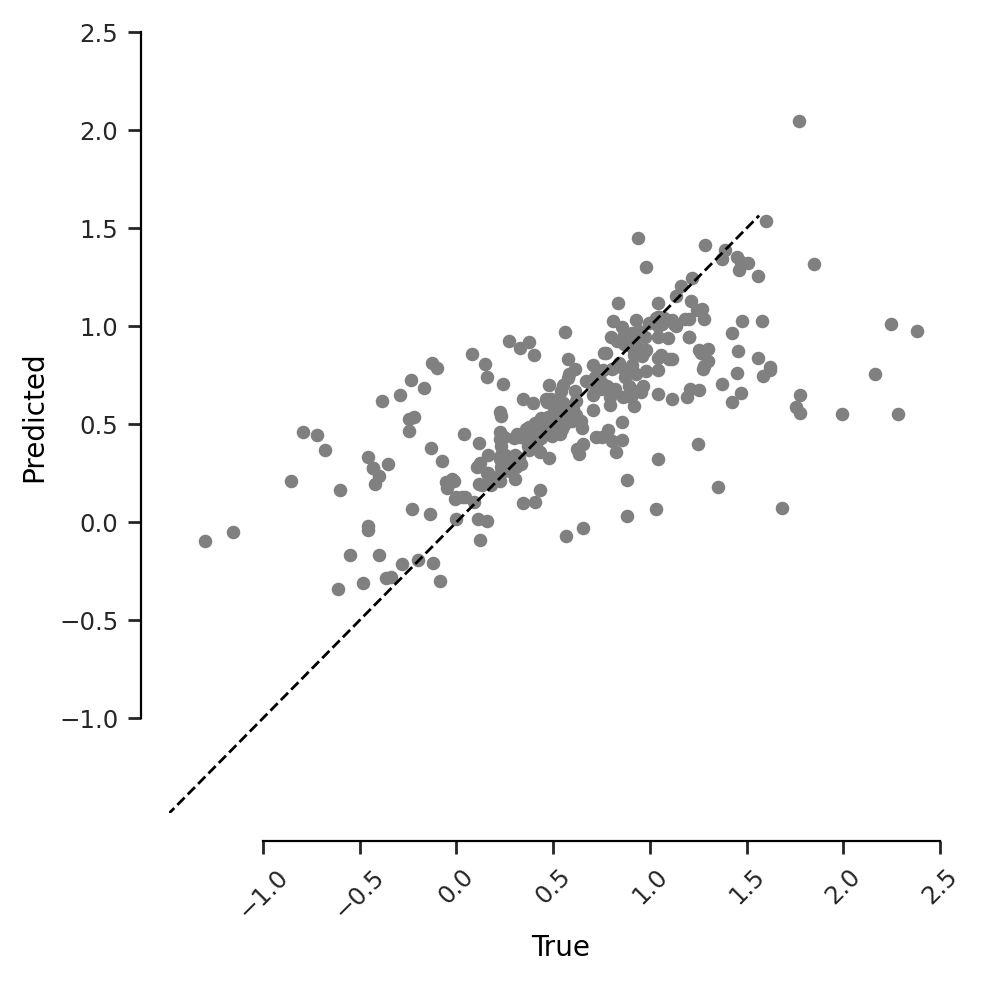

human_VDss_L_kg
(51,)
(51,)
2-fold :  52.94117647058824
3-fold :  68.62745098039215
5-fold :  84.31372549019608
gmfe :  2.464982340720707
mfe :  1.3323757050775793
bias :  -0.01759238041249611
rmse  0.55868650712837
r2  0.3870662642682944


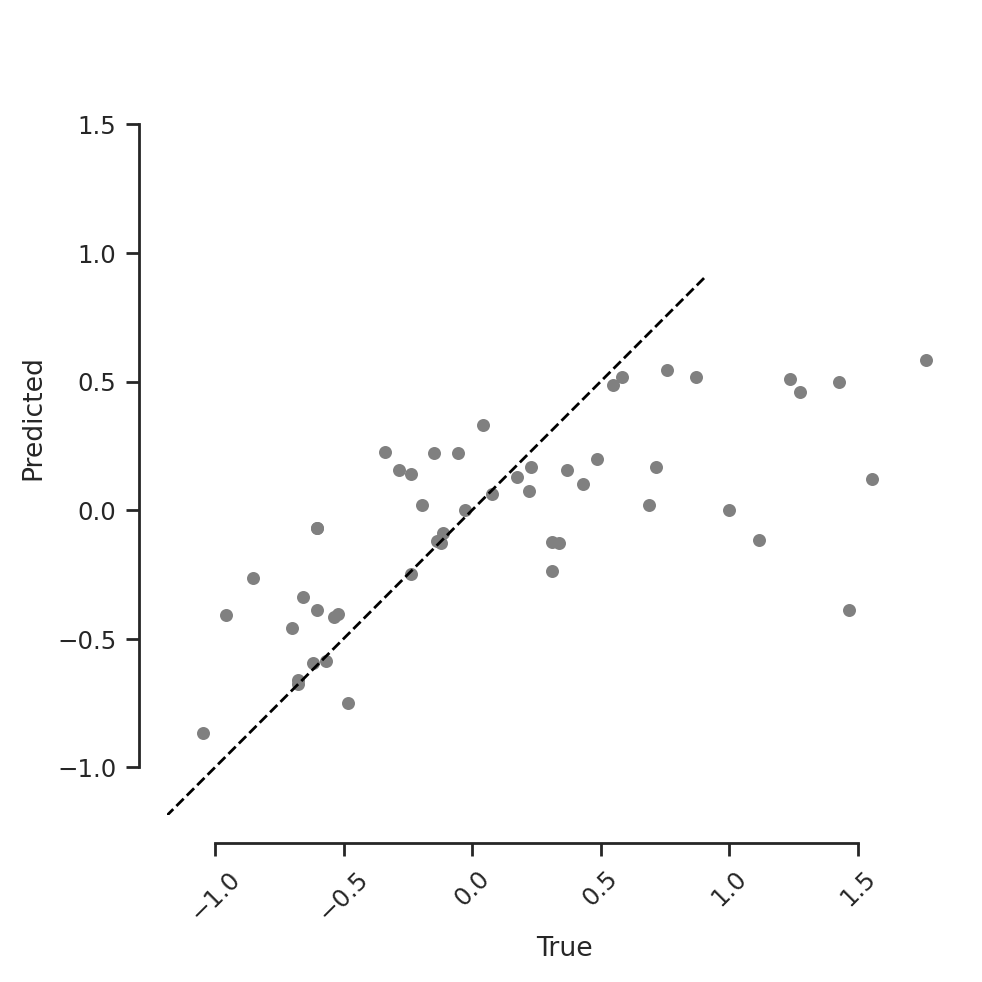

human_fup
(34,)
(34,)
2-fold :  26.47058823529412
3-fold :  41.17647058823529
5-fold :  61.76470588235294
gmfe :  4.124032669669152
mfe :  1.7591008321828814
bias :  0.055215268161272715
rmse  0.220852904777338
r2  0.25789306335550644


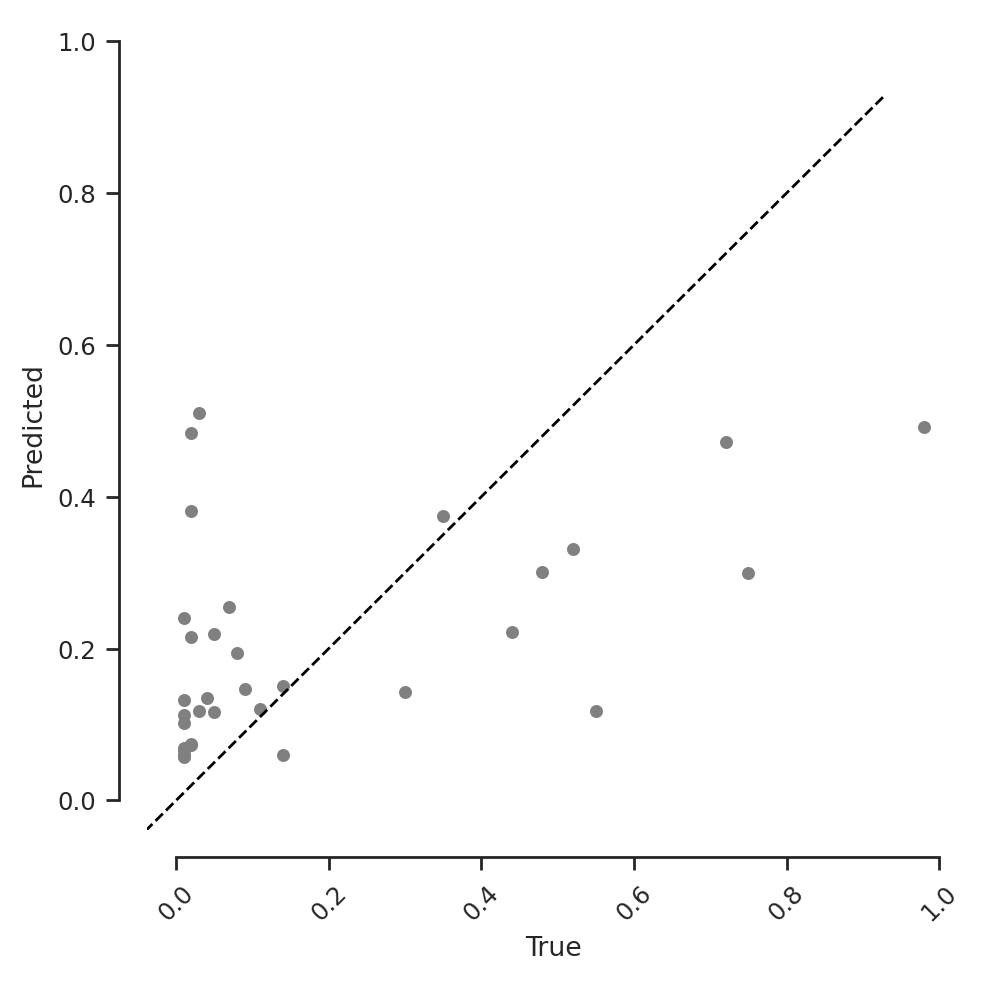

human_thalf
(38,)
(38,)
2-fold :  31.57894736842105
3-fold :  60.526315789473685
5-fold :  76.31578947368422
gmfe :  3.3092447750894722
mfe :  1.5027623897688553
bias :  -5.048851163459718
rmse  0.6821177711017584
r2  0.06348382729050195


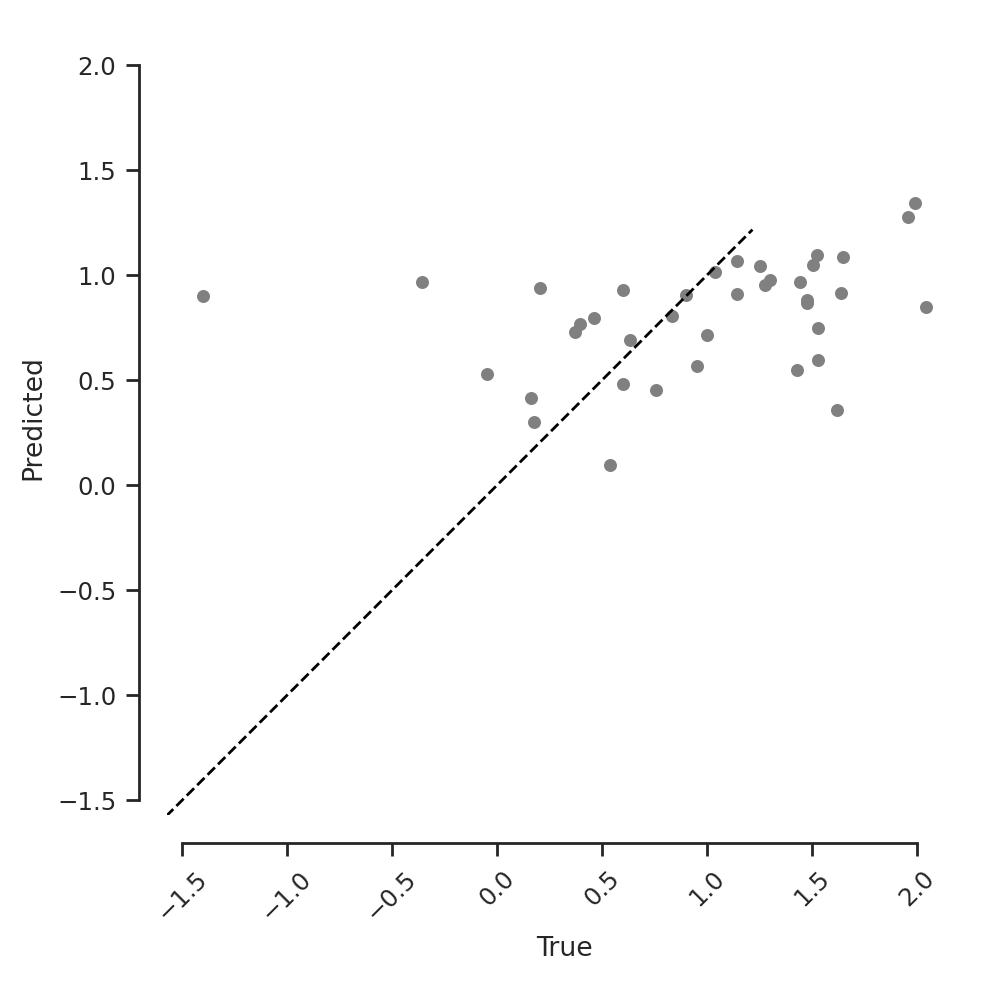

In [27]:
for endpoint in ["human_CL_mL_min_kg","human_VDss_L_kg","human_fup","human_thalf"]:
    
    print(endpoint)

    Y_test = df[[endpoint]].dropna().values.flatten()
    print(Y_test.shape)
    y_pred = preds[[endpoint]].iloc[df[[endpoint]].dropna().index].values.flatten()
    print(y_pred.shape)

    fold_2= count(y_pred, Y_test, 0.5, 2, endpoint)
    fold_3= count(y_pred, Y_test, 1/3, 3, endpoint)
    fold_5= count(y_pred, Y_test, 1/5, 5, endpoint)
    gmfe = calc_gmfe(y_pred, Y_test, endpoint)
    mfe = median_fold_change_error(y_pred, Y_test, endpoint)
    bias = calc_bias(y_pred, Y_test, endpoint)

    print("2-fold : ", fold_2)
    print("3-fold : ", fold_3)
    print("5-fold : ", fold_5)
    print("gmfe : ", gmfe)
    print("mfe : ", mfe)
    print("bias : ", bias)

    rmse = sqrt(mean_squared_error(Y_test, y_pred))
    print('rmse ',rmse)
    r2 = r2_score(Y_test, y_pred)
    print('r2 ',r2)

    
    fig = plt.figure(figsize =(5, 5), dpi=200) 

    plt.scatter(Y_test,  y_pred, color = 'gray', s=15) # s controls point size
    xleft, xright = plt.xlim()
    ybottom, ytop = plt.ylim()

    plt.xlim(min(xleft,ybottom) ,max(xright,ytop))
    plt.ylim(min(xleft,ybottom),max(xright,ytop))

    #add y=x line
    if (endpoint!="human_fup"):
        plt.plot([min(xleft,ybottom)-2,max(xright,ytop)-1],[min(xleft,ybottom)-2,max(xright,ytop)-1], lw=1, color='black', linestyle='dashed')

    else:
        plt.plot([min(xleft,ybottom)-0.2,max(xright,ytop)-0.1],[min(xleft,ybottom)-0.2,max(xright,ytop)-0.1], lw=1, color='black', linestyle='dashed')
    
    sns.set_context("paper", font_scale=1)
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title("")

    sns.set_style('ticks')
    sns.despine(offset=10, trim=True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [28]:
##END HERE


#combine 4g and 4f


In [29]:
df

,smiles_r,human_CL_mL_min_kg,human_VDss_L_kg,human_fup,human_thalf
0,C/[NH+]=C1/C[NH+](O)C(c2ccccc2)=c2cc(Cl)ccc2=N1,-0.431798,-0.602060,NaN,NaN
1,C1=C/COCc2cc(ccc2OCC[NH+]2CCCC2)Nc2nccc(n2)-c2...,-0.236572,0.582063,0.01,1.442480
2,C=C/C=C/C[C@@H](C)[C@@H](O)C1C(=O)NC(CC)C(=O)[...,1.247237,1.555094,0.03,1.477121
3,C=C1CC[C@]2(O)[C@@H]3Cc4ccc([O-])c5c4[C@]2(CC[...,1.158362,NaN,NaN,NaN
4,C=C1C[C@@H]2C(CC[C@]3(C)C(=O)CC[C@@H]23)[C@]2(...,2.161368,NaN,NaN,NaN
...,...,...,...,...,...
310,[O-]c1ccc(CC[NH2+]CCCCCC[NH2+]CCc2ccccc2)cc1[O-],1.556303,NaN,NaN,NaN
311,[O-]c1ccc2c(c1)C13CCCC[C@@]1(O)[C@H](C2)[NH+](...,1.602060,NaN,NaN,NaN
312,[O-]c1ccc2c3c1O[C@@H]1[C@@H](O)CC[C@]4(O)[C@H]...,1.472756,NaN,NaN,NaN
313,[O-]c1ncnc2[n-]ncc12,0.995635,NaN,NaN,NaN
